In [1]:
import sys,os
import numpy as np
import pandas as pd
import time, datetime
import random
import argparse
import math

import matplotlib.pyplot as plt


%matplotlib inline

### Modifications
 * pre-clustering of binary matrix reduces initial number of gene clusters
 * create UP- and DOWN- regulated matrice when run GMM binarization

In [2]:
min_n_samples = -1
direction = "DOWN"
out_dir = os.getcwd()+"/"
basename = "tmp"
seed = 42
alpha = 1.0
beta_K = 1.0
min_SNR = 1.5

# convergence
max_n_steps= 200
n_steps_averaged = 20
n_steps_for_convergence = 5
min_pletau_steps = 20
n_points_fit=10

verbose = True
plot_all = True

random.seed(seed)

#exprs_file = "../../DESMOND/simulated_datasets_backup2/exprs/simulated.N=10.Mu=2.0.GxP=100,100.overlap=TT.exprs.tsv"
#network_file = "../../DESMOND/simulated_datasets_backup2/networks/simulated.N=10.Mu=2.0.GxP=100,100.overlap=TT.tab"
#network_file = "/home/olya/SFU/Breast_cancer/DESMOND/BioGrid_human.tab"
#exprs_file = "../../Expression/Harmonized_final/TCGA_RNAseq.RSEM.log2.z.13K_common.tsv"
exprs_file = "../../Expression/Harmonized_final/TCGA_micro_nolog2.z.13K_common.tsv"

In [3]:
start_time = time.time()

if basename:
    basename = basename
else: 
    [date_h,mins] = str(datetime.datetime.today()).split(":")[:2]
    [date, hs] = date_h.split()
    basename = "results_"+hs+":"+mins+"_"+date 
    
suffix  = ".alpha="+str(alpha)+",beta_K="+str(beta_K)+",direction="+direction
if verbose:
    print("Will save output files to:",out_dir + basename + suffix, file = sys.stdout)
    
# read inputs
exprs = pd.read_csv(exprs_file, sep="\t",index_col=0)

# define minimal number of patients in a module
if min_n_samples == -1:
    min_n_samples = int(max(10,0.05*exprs.shape[1])) # set to max(10, 5% of the cohort) 
if verbose:
    print("Mininal number of samples in a module:",min_n_samples ,file=sys.stdout)

Will save output files to: /home/olya/SFU/Breast_cancer/DESMOND2/DESMOND2/tmp.alpha=1.0,beta_K=1.0,direction=DOWN
Mininal number of samples in a module: 26


# 1) Assign patients to edges
 * GMM
 * filtering by sample nubmer and SNR

In [4]:
from method2 import GM_binarization

		genes processed: 0
Gene SIDT1: SNR=-2.03, bicluster=92, bg=437


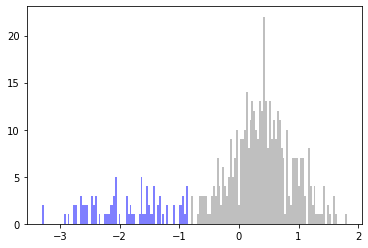

Gene CLIC6: SNR=-2.01, bicluster=186, bg=343


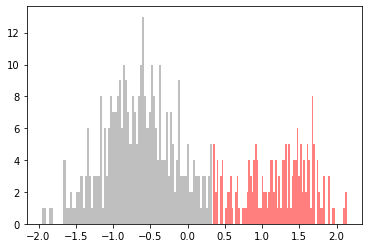

		genes processed: 1000
		genes processed: 2000
		genes processed: 3000
Gene GRB7: SNR=2.52, bicluster=54, bg=475


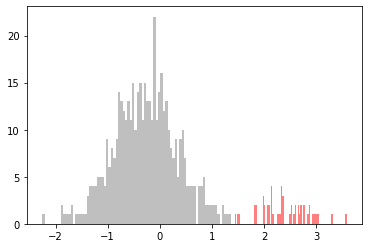

		genes processed: 4000
		genes processed: 5000
Gene ESR1: SNR=-2.21, bicluster=134, bg=395


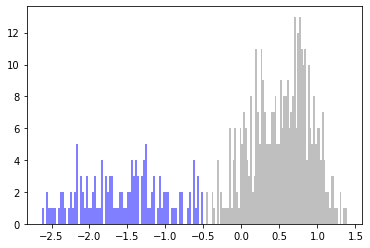

		genes processed: 6000
		genes processed: 7000
		genes processed: 8000
Gene ERBB2: SNR=2.19, bicluster=57, bg=472


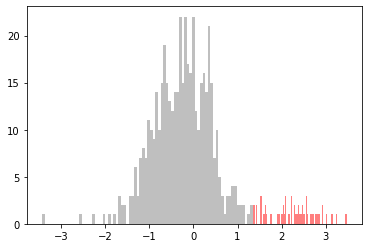

Gene GATA3: SNR=-1.73, bicluster=125, bg=404


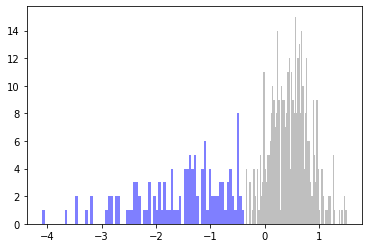

		genes processed: 9000
Gene FOXA1: SNR=-2.57, bicluster=94, bg=435


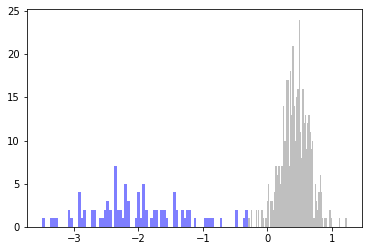

		genes processed: 10000
		genes processed: 11000
Gene BMPR1B: SNR=-2.15, bicluster=243, bg=286


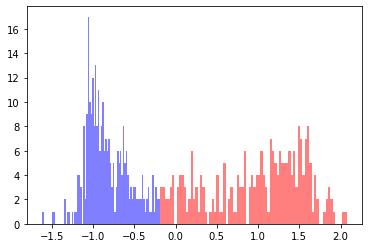

		genes processed: 12000
		genes processed: 13000
Total runtime 129.22 s for  13361 genes
Genes passed SNR threshold of 1.5:
	up-regulated genes: 1016
	down-regulated genes: 478
	inexplicit genes: 103


((529, 1016), (529, 478))

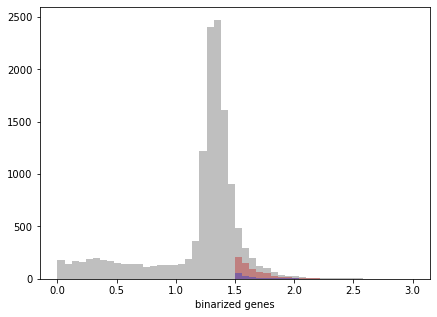

In [5]:
sele_genes = ["SIDT1","CLIC6","BMPR1B", "FOXA1","GATA3","ESR1","ERBB2","GRB7"]
binarized_expressions = GM_binarization(exprs,min_SNR,min_n_samples,verbose = True, 
                                        plot=True, plot_SNR_thr= 3.0, show_fits = sele_genes)
binarized_expressions["UP"].shape, binarized_expressions["DOWN"].shape    

# Step 2. Sample module memberships

In [6]:
from method2 import set_initial_conditions, sampling, get_consensus_modules

In [7]:
exprs_bin = binarized_expressions[direction]
print(exprs_bin.shape)
exprs_bin.columns

(529, 478)


Index(['ASS1', 'GRP', 'THSD4', 'CADPS2', 'ABAT', 'CFB', 'SIDT1', 'SIX2',
       'C4orf19', 'IGFBP2',
       ...
       'RNF39', 'EPB41L4A', 'STYK1', 'FAM110C', 'SURF1', 'GBP3', 'STK36',
       'EMX2', 'GRPR', 'ABCC8'],
      dtype='object', length=478)

In [8]:
# simplifying probability calculations
N = exprs.shape[1]
max_log_float = np.log(np.finfo(np.float64).max)
n_exp_orders = 7 # ~1000 times 
p0 = N*np.log(0.5)+np.log(beta_K)
match_score = np.log((alpha*0.5+1)/(alpha))
mismatch_score = np.log((alpha*0.5+0)/alpha)
bK_1 = math.log(1+beta_K)
genes = exprs_bin.columns.values

In [9]:
print("Direction:",direction)
moduleSizes, gene2Samples, nOnesPerSampleInModules, gene2Module, moduleOneFreqs, LP  = set_initial_conditions(exprs_bin, alpha,beta_K,verbose = True)
K = len(moduleSizes)
N = gene2Samples.shape[1]
print("\t\tLP memory, {:.2f} M".format(LP.nbytes/(1024*1024)),file = sys.stdout)


Direction: DOWN
		KxN=478x529
		p0= -366.67485851621103
time:	Initial state created in 1.4 s.
		LP memory, 1.74 M


In [10]:
t0 = time.time()
gene2Module_history,n_final_steps,n_skipping_genes,P_diffs = sampling(LP,gene2Module, gene2Samples, nOnesPerSampleInModules,moduleSizes,moduleOneFreqs, p0, match_score,mismatch_score, bK_1, alpha, beta_K, 
                                                                          max_n_steps=max_n_steps, n_steps_averaged = n_steps_averaged, n_points_fit = n_points_fit, tol = 0.1, 
                                                                          n_steps_for_convergence = n_steps_for_convergence, verbose=True)

print("time:\tSampling (%s steps) fininshed in %s s." %(len(gene2Module_history),round(time.time()-t0,2)), file = sys.stdout)


step 1


/home/olya/SFU/Breast_cancer/DESMOND2/DESMOND2/method2.py:151: RuntimeWarning: invalid value encountered in log
  ones_matching_term = np.inner(np.log(oneRatios),gene_vector)
/home/olya/SFU/Breast_cancer/DESMOND2/DESMOND2/method2.py:154: RuntimeWarning: invalid value encountered in log
  zeros_matching_term = np.inner(np.log(zeroRatios),(1-gene_vector))


	step  1 8.4 s
step 2
	step  2 1.5 s
step 3
	step  3 0.7 s
step 4
	step  4 0.5 s
step 5
	step  5 0.3 s
step 6
	step  6 0.4 s
step 7
	step  7 0.4 s
step 8
	step  8 0.3 s
step 9
	step  9 0.3 s
step 10
	step  10 0.3 s
step 11
	step  11 0.3 s
step 12
	step  12 0.3 s
step 13
	step  13 0.3 s
step 14
	step  14 0.3 s
step 15
	step  15 0.3 s
step 16
	step  16 0.3 s
step 17
	step  17 0.3 s
step 18
	step  18 0.3 s
step 19
	step  19 0.3 s
step 20
	step  20 0.3 s
step 21
	step  21 0.3 s
step 22
	step  22 0.3 s
step 23
	step  23 0.3 s
step 24
	step  24 0.3 s
step 25
	step  25 0.3 s
step 26
	step  26 0.3 s
step 27
	step  27 0.3 s
step 28
	step  28 0.4 s
step 29
	step  29 0.3 s
step 30
	step  30 0.3 s
	Converged: False #skipping edges slope: -0.10614
step 31
	step  31 0.3 s
	Converged: True #skipping edges slope: -0.03672
step 32
	step  32 0.3 s
	Converged: True #skipping edges slope: -0.0109
step 33
	step  33 0.3 s
	Converged: True #skipping edges slope: 0.00096
step 34
	step  34 0.3 s
	Converged: Tr

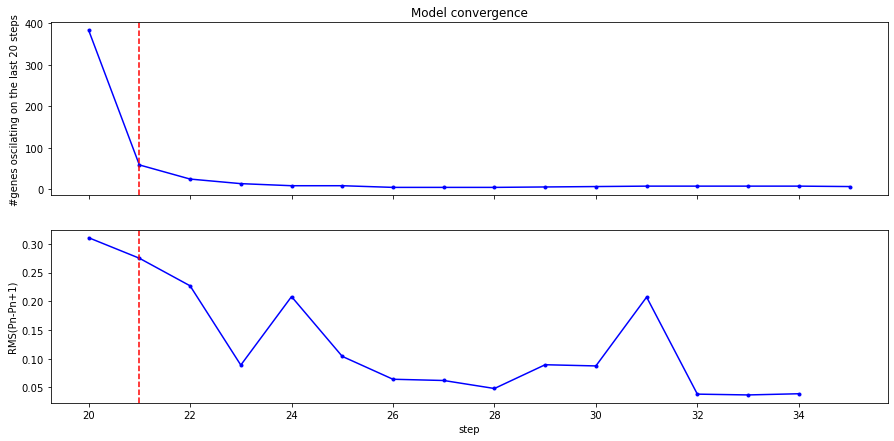

In [11]:
if plot_all:
    from method2 import plot_convergence
    plot_outfile = out_dir + basename +suffix+",ns_max=" + str(max_n_steps)+ ",ns_avg=" + str(n_steps_averaged) + ",ns_c="+str(n_steps_for_convergence) + ".convergence.svg"
    plot_convergence(n_skipping_genes, P_diffs,len(gene2Module_history)-n_final_steps,
                     n_steps_averaged, outfile=plot_outfile)


In [12]:

consensus, nOnesPerSampleInModules, moduleSizes, moduleOneFreqs = get_consensus_modules(gene2Module_history[-n_final_steps:], LP,  gene2Samples, gene2Module,
                      nOnesPerSampleInModules,moduleSizes, moduleOneFreqs, p0, match_score,mismatch_score,
                      bK_1,alpha,beta_K,N, K)

print("\tEmpty modules:", len([x for x in moduleSizes if x == 0]),
  "\n\tNon-empty modules:",len([x for x in moduleSizes if x > 0]),file = sys.stdout)

print("size(genes)\tn_modules")
for m in set(moduleSizes):
    print(m, "\t\t",len([x for x in moduleSizes if x==m]))

	edge: 433 counts: [5 6 4] 
	labels: 281,428,433
3 genes changed their module membership after taking consensus.
	Empty modules: 301 
	Non-empty modules: 177
size(genes)	n_modules
0 		 301
1 		 34
2 		 133
3 		 5
4 		 1
5 		 1
39 		 1
8 		 1
107 		 1


# 3) Define biclusters

In [13]:
exprs_np = exprs.loc[genes,:]
ints2g_names = exprs_np.index.values
ints2s_names = exprs_np.columns.values
exprs_np = exprs_np.values
exprs_sums = exprs_np.sum(axis=1)
exprs_sq_sums = np.square(exprs_np).sum(axis=1)
N = exprs.shape[1]
exprs_data = N, exprs_sums, exprs_sq_sums

In [14]:
from method2 import genesets2biclusters,  write_bic_table

# Identify optimal patient sets for each module: split patients into two sets in a subspace of each module
# Filter out bad biclusters with too few genes or samples, or with low SNR
filtered_bics = genesets2biclusters(exprs_np, exprs_data,moduleSizes,consensus,
                        min_SNR = 0.5,direction=direction,min_n_samples=min_n_samples,
                        verbose = verbose)
i =0
print()
for bic in filtered_bics:
    bic["id"] = i
    i+=1
    bic["genes"] = set(sorted([ints2g_names[x] for x in bic["genes"]]) )
    bic["samples"] = set(sorted([ints2s_names[x] for x in bic["samples"]]))
    if len(bic["genes"])>2:
        print("\t".join(map(str,[str(bic["n_genes"])+"x"+str(bic["n_samples"]),
                                 round(bic["avgSNR"],3)," ".join(bic["genes"])])),file = sys.stdout)

time:	Identified optimal sample sets for 478 modules in 5.15 s.
	Empty modules: 34
	Modules with just 1 edge: 34
	Modules with not enough or too many samples: 0
	Modules not passed avg. |SNR| threshold: 1
Passed modules with >= 2 genes and >= 26 samples: 142

3x210	1.52	ADH1C ADH1A FABP4
3x210	1.256	COL17A1 CALML3 KRT6B
8x205	1.002	TSHZ3 GRP F13A1 P4HA3 LRRC17 HTRA1 STMN2 SORCS2
5x184	0.834	CCL19 CCL18 GZMK IGSF6 PTGDS
3x152	1.624	SCGB1D1 SCGB2A2 SCGB1D2
3x306	1.566	CIDEA MRAP LEP
4x165	0.736	LIMCH1 EHF KRT7 TMPRSS2
106x104	1.05	ABCC8 STK36 SIDT1 SPRED2 CMBL KRT18 RTN4RL1 IGFBP2 RALGPS2 ACADSB AZGP1 THSD4 C9orf116 ANXA9 PRR15 TOX3 TSPAN1 AGR2 RAB11A RERG ZNF516 LIMA1 HPN FBP1 ERBB4 XBP1 ARSG REEP1 TFF3 TINF2 IQCH BTF3 IGFALS LRFN2 CRIP1 ST6GALNAC2 SPDEF TOX4 HDAC11 ZMYND10 GPRC5C NPDC1 NPNT MLPH SYTL2 AR TSC22D3 RHOB SURF1 LIPH EPS8L1 MYB SYTL4 GATA3 SERINC2 GSTO2 PIP REEP6 P2RX4 CDS1 ESR1 NDUFS4 SLC22A5 TRPM4 DYNLRB2 FBXL5 GAMT LRRC56 THBS1 WFS1 MSX2 INPP4B SELENBP1 SYT17 ZNF552 SLC7A

In [15]:
result_file_name = out_dir+basename+suffix
write_bic_table(filtered_bics,
                result_file_name+".biclusters.tsv")


print("Total runtime:",round(time.time()-start_time,2),file = sys.stdout)

Total runtime: 161.65


In [16]:
print(result_file_name)

/home/olya/SFU/Breast_cancer/DESMOND2/DESMOND2/tmp.alpha=1.0,beta_K=1.0,direction=DOWN


# All steps in one function

In [17]:
import sys,os
import numpy as np
import pandas as pd
import time, datetime
import random
import argparse
import math

import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
from method2 import GM_binarization
from method2 import set_initial_conditions, sampling, get_consensus_modules
from method2 import genesets2biclusters,  write_bic_table

In [19]:
def run_DESMOND(exprs_file, out_dir = "./",basename = False,
                min_n_samples = -1,min_SNR = 1.5,
                alpha=1.0 ,beta_K=1.0, 
                max_n_steps= 200, n_steps_averaged = 20, n_steps_for_convergence = 5, n_points_fit=10,
                plot_all=True, verbose = True):
    
    biclusters = {} # UP and DOWN
    start_time = time.time()

    if basename:
        basename = basename
    else: 
        [date_h,mins] = str(datetime.datetime.today()).split(":")[:2]
        [date, hs] = date_h.split()
        basename = "results_"+hs+":"+mins+"_"+date 

    suffix  = ".alpha="+str(alpha)+",beta_K="+str(beta_K)+",minSNR="+str(min_SNR)
    if verbose:
        print("Will save output files to: %s*."% (out_dir + basename + suffix), file = sys.stdout)

    # read inputs
    exprs = pd.read_csv(exprs_file, sep="\t",index_col=0)

    # define minimal number of patients in a module
    if min_n_samples == -1:
        min_n_samples = int(max(10,0.05*exprs.shape[1])) # set to max(10, 5% of the cohort) 
    if verbose:
        print("Mininal number of samples in a module:",min_n_samples ,file=sys.stdout)
    ####1. Binarization ####
    sele_genes = ["SIDT1","CLIC6","BMPR1B", "FOXA1","GATA3","ESR1","ERBB2","GRB7"]
    binarized_expressions = GM_binarization(exprs,min_SNR,min_n_samples,verbose = verbose,
                                 plot=plot_all, plot_SNR_thr= 2.5,show_fits=sele_genes)    
    ### 2. Edge clustering ###
    
    # simplifying probability calculations
    N = exprs.shape[1]
    max_log_float = np.log(np.finfo(np.float64).max)
    n_exp_orders = 7 # ~1000 times 
    p0 = N*np.log(0.5)+np.log(beta_K)
    match_score = np.log((alpha*0.5+1)/(alpha))
    mismatch_score = np.log((alpha*0.5+0)/alpha)
    bK_1 = math.log(1+beta_K)
    
    i = 0
    for direction in ["UP","DOWN"]:
        t1 = time.time()
        exprs_bin = binarized_expressions[direction]
        genes = exprs_bin.columns.values
        # setting initial model state
        print("Searching for %s-regulated biclusters ..."%direction)
        moduleSizes, gene2Samples, nOnesPerSampleInModules, gene2Module, moduleOneFreqs, LP  = set_initial_conditions(exprs_bin, alpha,beta_K,verbose = verbose)
        K = len(moduleSizes)
        N = gene2Samples.shape[1]
        print("\t\tLP matrix memory usage: {:.2f}M".format(LP.nbytes/(1024*1024)),file = sys.stdout)

        # sampling
        t0 = time.time()
        gene2Module_history,n_final_steps,n_skipping_genes,P_diffs = sampling(LP,gene2Module, gene2Samples, nOnesPerSampleInModules,
                                                                              moduleSizes,moduleOneFreqs, p0, match_score,mismatch_score,
                                                                              bK_1, alpha, beta_K, max_n_steps=max_n_steps, tol = 0.1,
                                                                              n_steps_averaged = n_steps_averaged, n_points_fit = n_points_fit, 
                                                                              n_steps_for_convergence = n_steps_for_convergence, verbose=True)

        print("time:\tSampling (%s steps) fininshed in %s s." %(len(gene2Module_history),round(time.time()-t0,2)), file = sys.stdout)
        if plot_all:
            from method2 import plot_convergence
            plot_outfile = out_dir + basename +suffix+",ns_max=" + str(max_n_steps)+ ",ns_avg=" + str(n_steps_averaged) + ",ns_c="+str(n_steps_for_convergence) + ".convergence.svg"
            plot_convergence(n_skipping_genes, P_diffs,len(gene2Module_history)-n_final_steps,
                             n_steps_averaged, outfile=plot_outfile)

        # take the last (n_points_fit+n_steps_for_convergence) steps modules:
        # and get consensus edge-to-module membership
        consensus, nOnesPerSampleInModules, moduleSizes, moduleOneFreqs = get_consensus_modules(gene2Module_history[-n_final_steps:], 
                                                                                                LP, gene2Samples, gene2Module,
                                                                                                nOnesPerSampleInModules,moduleSizes, 
                                                                                                moduleOneFreqs, p0, 
                                                                                                match_score,mismatch_score,
                                                                                                bK_1,alpha,beta_K,N,K)

        print("\tEmpty modules:", len([x for x in moduleSizes if x == 0]),
              "\n\tNon-empty modules:",len([x for x in moduleSizes if x > 0]),file = sys.stdout)
        #### 3. Define biclusters and merge modules  ####
        exprs_np = exprs.loc[genes,:]
        ints2g_names = exprs_np.index.values
        ints2s_names = exprs_np.columns.values
        exprs_np = exprs_np.values
        exprs_sums = exprs_np.sum(axis=1)
        exprs_sq_sums = np.square(exprs_np).sum(axis=1)
        N = exprs.shape[1]
        exprs_data = N, exprs_sums, exprs_sq_sums
        # Identify optimal patient sets for each module: split patients into two sets in a subspace of each module
        # Filter out bad biclusters with too few genes or samples, or with low SNR
        filtered_bics = genesets2biclusters(exprs_np, exprs_data,moduleSizes,consensus,
                                min_SNR = 0.5,direction=direction,min_n_samples=min_n_samples,
                                verbose = verbose)
        # print info on found biclusters
        if verbose:
            for bic in filtered_bics:
                bic["id"] = i
                i+=1
                bic["genes"] = sorted([ints2g_names[x] for x in bic["genes"]])
                bic["samples"] = sorted([ints2s_names[x] for x in bic["samples"]])
                if len(bic["genes"])>2:
                    print("\t".join(map(str,[str(bic["n_genes"])+"x"+str(bic["n_samples"]),
                                             round(bic["avgSNR"],3)," ".join(bic["genes"])])),file = sys.stdout)
                        
        # save results 
        result_file_name = out_dir+basename+suffix+",direction="+direction
        write_bic_table(filtered_bics,result_file_name+".biclusters.tsv")
        if verbose:
            print("Runtime for %s-regulated biclusters: %s"%(direction, round(time.time()-t1,2)),file = sys.stdout)
        biclusters[direction] = filtered_bics
    
    biclusters = biclusters["UP"] + biclusters["DOWN"]
    result_file_name = out_dir+basename+suffix
    write_bic_table(biclusters,result_file_name+".biclusters.tsv")
    if verbose:
        print("Total runtime:",round(time.time()-start_time,2),file = sys.stdout)
        
    return biclusters

#exprs_file = "../../Expression/Harmonized_final/TCGA_micro_nolog2.z.13K_common.tsv"
#biclusters_TCGA_micro = run_DESMOND(exprs_file,basename = "TCGA_micro",min_SNR=2.0)